# 在Cython中使用SciPy中的LowLevelCallable

在SciPy 0.19中提供了`LowLevelCallable`对C、Cython或者numba编写的函数进行包装，让主循环能够快速调用这些函数。例如`scipy.integrate.quad()`就支持`LowLevelCallable`。然而SciPy并没有公开`LowLevelCallable`的API，我们无法创建自己的调用`LowLevelCallable`的函数。

本书提供的`ccallback`模块将SciPy中`LowLevelCallable`相关的C语言代码包装，让我们在Cython的模块中可以定义调用`LowLevelCallable`的函数。下面介绍如何创建该模块。

首先下载SciPy中相关的C语言文件：https://github.com/scipy/scipy/blob/master/scipy/_lib/src/ccallback.h

然后使用下面两个文件对其进行包装：

### callback.pxd

```cython
from libc.setjmp cimport jmp_buf
from cpython.object cimport PyObject

ctypedef struct callback_signature_t "callback_signature_t":
    char *signature
    int value

ctypedef struct callback_t "callback_t":
    void *c_function
    PyObject *py_function
    void *user_data
    callback_signature_t *signature   
    jmp_buf error_buf
    callback_t *prev_callback

    # Unused variables that can be used by the thunk etc. code for any purpose
    long info
    void *info_p

cdef callback_t * callback_obtain()
cdef int callback_prepare(callback_t *callback, callback_signature_t *sigs,
                        object func, int flags) except -1
cdef void callback_release(callback_t *callback)
```

### callback.pyx

```cython
from libc.setjmp cimport jmp_buf
from cpython.object cimport PyObject
cimport callback

cdef extern from "ccallback.h":
    ctypedef struct ccallback_signature_t:
        char *signature
        int value

    ctypedef struct ccallback_t:
        void *c_function
        PyObject *py_function
        void *user_data
        ccallback_signature_t *signature        
        jmp_buf error_buf
        ccallback_t *prev_callback

        # Unused variables that can be used by the thunk etc. code for any purpose
        long info
        void *info_p

    ccallback_t *ccallback_obtain()
    int ccallback_prepare(ccallback_t *callback, ccallback_signature_t *sigs,
                          object func, int flags) except -1
    void ccallback_release(ccallback_t *callback)


cdef callback_t * callback_obtain():
    return <callback_t *>ccallback_obtain()


cdef int callback_prepare(callback_t *callback, callback_signature_t *sigs,
                        object func, int flags) except -1:
    return ccallback_prepare(<ccallback_t *>callback, <ccallback_signature_t *>sigs, func, flags)


cdef void callback_release(callback_t *callback):
    ccallback_release(<ccallback_t *>callback)
```

最后使用下面的`setup.py`将它们编译成扩展库：

### setup.py

```python
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext

setup(
    cmdclass={'build_ext': build_ext},
    ext_modules=[
        Extension("callback", ["callback.pyx"]),
    ],
    include_dirs=["."],
)
```

运行`python setup.py build_ext --inplace`进行编译。

In [1]:
%load_ext cython
%matplotlib inline
import pylab as pl

`ccallback.callback`模块是专门供Cython使用的模块，在Cython中使用如下命令载入`callback.pxd`中定义的结构体和函数。

```
from ccallback.callback cimport callback_t, callback_prepare, callback_release, callback_signature_t
```

其中:

* `callback_t`是SciPy中将Python对象转换之后供C语言调用的结构体。当对象是一般的Python函数时，其`py_function`字段指向该函数，当对象是`LowLevelCallable`时，其`c_function`指向该函数。此外，它还支持对多个不同调用参数的函数，每个函数与一个`callback_signature_t`结构体对应。其`signature`是表示函数签名的字符串，`value`是函数的标识。

* `ccallback_prepare(ccallback_t *callback, ccallback_signature_t *sigs, object func, int flags)`将`func`转换为`callback`结构体，`sigs`是指向`callback_signature_t`结构体数组的指针。当`func`是`LowLevelCallable`对象时，`ccallback_prepare()`找到`sigs`中与其对应的函数签名，并将该结构体的地址写入`callback.signature`字段。

下面是使用`ccallback.callback`的一个例子。`euler()`是使用欧拉法解常微分方程的函数。它支持Python函数和`LowLevelCallable`对象。

In [2]:
%%cython
import cython
import numpy as np
cimport numpy as np
from cpython.tuple cimport PyTuple_New, PyTuple_SET_ITEM
from cpython.ref cimport Py_INCREF
from cpython.float cimport PyFloat_FromDouble
from ccallback.callback cimport callback_t, callback_prepare, callback_release, callback_signature_t

cdef callback_signature_t signatures[2]
signatures[0].signature = "void (double *, double *, double, long, void *)"
signatures[0].value = 0
signatures[1].signature = NULL

ctypedef void (*Function)(double * x, double * dx, double t, long n, void *data) nogil

@cython.boundscheck(False)
cdef void callback_for_python_gil(double * x, double * dx, double t, long n, void *data):
    cdef:
        callback_t *callback = <callback_t *>data
        double result = 0
        double v
        long i
        tuple x_obj
        object obj

    x_obj = PyTuple_New(n)

    for i in range(n):
        obj = PyFloat_FromDouble(x[i])
        PyTuple_SET_ITEM(x_obj, i, obj)
        Py_INCREF(obj)

    res = (<object>callback.py_function)(x_obj, t)

    for i, v in enumerate(res):
        dx[i] = v
    
cdef void callback_for_python(double * x, double * dx, double t, long n, void *data) nogil:
    with gil:
        callback_for_python_gil(x, dx, t, n, data)
    
@cython.boundscheck(False)
def euler(func, x0, double dt, int n):
    cdef:
        callback_t callback
        Function function 
        double[::1] status
        double[::1] dstatus
        double t
        long m, i, j
        double[:, ::1] result
    
    callback_prepare(&callback, signatures, func, 0)
    if callback.c_function != NULL:
        function = <Function>callback.c_function
    else:
        function = <Function>callback_for_python
        
    m = len(x0)
    status = np.ascontiguousarray(x0, dtype=float)
    dstatus = np.empty(m)
    t = 0.0
    result = np.empty((n, m))

    with nogil:
        for i in range(n):
            function(&status[0], &dstatus[0], t, m, <void *>&callback)
            for j in range(m):
                result[i, j] = status[j]
                status[j] += dstatus[j] * dt
            t += dt

    callback_release(&callback)

    return result.base                         

将`func`转换为`callback`结构体之后，判断其`c_function`字段是否为`NULL`。如果不为`NULL`则将其值赋值给函数指针`function`。如果为`NULL`则说明参数`func`是一个Python函数，这时`function`函数指针指向`callback_for_python()`函数。

`Function`函数类型的最后一个参数是`void *data`，可以使用它传递任何数据，在本例中使用它传递`callback`结构体。在`callback_for_python()`中通过它找到Python函数并调用之。

下面使用`euler()`计算洛伦茨吸引子。首先测试使用Python函数。

Wall time: 475 ms


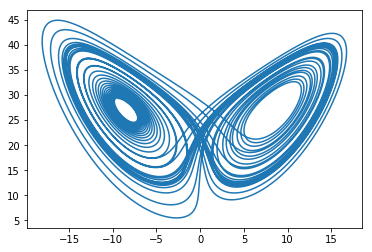

In [3]:
σ = 10.0
β = 8 / 3
ρ = 28.0

def lorenz_py(s, t):
    x, y, z = s
    return σ * (y - x), x * (ρ - z) - y, x * y - β * z

%time x, y, z = euler(lorenz_py, [1.0, 1.0, 1.0], 1e-4, 400000).T

pl.plot(x[10000:], z[10000:]);

接下来使用`numba.cfunc`定义一个低级函数`lorenz_nb`。然后通过`LowLevelCallable(lorenz_nb.ctypes)`将其转换为`LowLevelCallable`对象，并传递给`euler()`进行积分计算。与前面的Python函数相比，其运算速度快了近40多倍。

Wall time: 11 ms


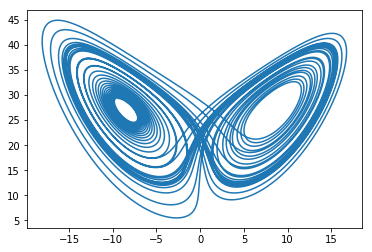

In [4]:
from numba import types
from numba import cfunc
from scipy import LowLevelCallable

@cfunc(types.void(types.CPointer(types.float64),
                  types.CPointer(types.float64),
                  types.float64, types.intc, types.voidptr))
def lorenz_nb(s, ds, t, n, data):
    x, y, z = s[0], s[1], s[2]
    ds[0] = σ * (y - x)
    ds[1] = x * (ρ - z) - y
    ds[2] = x * y - β * z

llcall = LowLevelCallable(lorenz_nb.ctypes)
%time x, y, z = euler(llcall, [1.0, 1.0, 1.0], 1e-4, 400000).T

pl.plot(x[10000:], z[10000:]);